In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here


env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
   """Multiply two numbers."""
   return a * b

In [3]:
from langchain_core.tools import tool
import requests

@tool
def get_weather(location: str) -> str:
    """Get weather information for a location using wttr.in. example: get_weather('Toldeo, Ohio') and output might be something like '☁️   +57°F'"""
    try:
        # Replace spaces with %20 for URL encoding
        location_encoded = location.replace(" ", "%20")
        url = f"https://wttr.in/{location_encoded}?format=1"
        response = requests.get(url)
        if response.status_code == 200:
            return response.text.strip()
        else:
            return f"Could not retrieve weather for {location} (status code: {response.status_code})"
    except Exception as e:
        return f"Error retrieving weather: {e}"

In [6]:
tool = get_weather
name = getattr(tool, 'name', str(tool))
description = getattr(tool, 'description', 'No description available')

# Try to get function signature from tool
if hasattr(tool, 'func') and hasattr(tool.func, '__annotations__'):
    # Get function signature from annotations
    func = tool.func
    sig_parts = []
    for param_name, param_type in func.__annotations__.items():
        if param_name != 'return':
            sig_parts.append(f"{param_name}: {param_type.__name__}")
    
    return_type = func.__annotations__.get('return', 'Any')
    return_type_name = return_type.__name__ if hasattr(return_type, '__name__') else str(return_type)
    
    signature = f"{name}({', '.join(sig_parts)}) -> {return_type_name}"
    
    # Include docstring if available
    docstring = getattr(func, '__doc__', None)
    if docstring:
        signature += f'\n    """{docstring.strip()}"""'
else:
    # Fallback to basic signature
    signature = f"{name}(...)"

print(signature)

get_weather(location: str) -> str
    """Get weather information for a location using wttr.in. example: get_weather('Toldeo, Ohio') and output might be something like '☁️   +57°F'"""


In [10]:
from typing import Dict, Any, List, Optional, Annotated
from pydantic import BaseModel, Field
import re
import sys
import os
import io
import contextlib
import traceback
import pathlib
from pathlib import Path
import glob
import shutil

# LangGraph imports
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class CodingAgentState(BaseModel):
    """State for the coding agent workflow"""
    
    # Core conversation
    messages: Annotated[List[BaseMessage], add_messages] = Field(default_factory=list)
    
    # Code generation and execution
    generated_code: Optional[str] = Field(default=None, description="Generated code from LLM")
    execution_result: Optional[str] = Field(default=None, description="Result of code execution")
    execution_error: Optional[str] = Field(default=None, description="Error from code execution")

    first_message: bool = False


In [ ]:
def create_coding_agent(llm, tools: List[Any] = None) -> StateGraph:
    """
    Create a simple langgraph coding agent with generate and execute nodes
    
    Args:
        llm: Language model (like ChatOpenAI with openrouter)
        tools: List of tools available to the agent
    
    Returns:
        Compiled StateGraph with checkpointer for stateful conversation
    """
    if tools is None:
        tools = []
    
    # Create function signatures for the system prompt
    function_signatures = []
    for tool in tools:
        name = getattr(tool, 'name', str(tool))
        description = getattr(tool, 'description', 'No description available')
        
        # Try to get function signature from tool
        
        # Try to get function signature from tool
        if hasattr(tool, 'func') and hasattr(tool.func, '__annotations__'):
            # Get function signature from annotations
            func = tool.func
            sig_parts = []
            for param_name, param_type in func.__annotations__.items():
                if param_name != 'return':
                    sig_parts.append(f"{param_name}: {param_type.__name__}")
            
            return_type = func.__annotations__.get('return', 'Any')
            return_type_name = return_type.__name__ if hasattr(return_type, '__name__') else str(return_type)
            
            signature = f"{name}({', '.join(sig_parts)}) -> {return_type_name}"
            
            # Include docstring if available
            docstring = getattr(func, '__doc__', None)
            if docstring:
                signature += f'\n    """{docstring.strip()}"""'
        else:
            # Fallback to basic signature
            signature = f"{name}(...)"
                
        function_signatures.append(f"- {signature}: {description}")
    
    functions_text = "\n".join(function_signatures) if function_signatures else "No functions available"
    
    # System prompt with available functions
    system_prompt = f"""You are a coding assistant that can generate and execute Python code.

You have access to these functions that are already imported and available:
{functions_text}

You can directly interact with the user's system and have full access to the file system with these modules already imported:
- os: Operating system interface
- pathlib, Path: Modern path handling
- glob: File pattern matching
- shutil: High-level file operations
- sys, io, contextlib, traceback, re: Standard Python utilities

Examples of file system operations you can perform:
- List desktop files: Path.home() / "Desktop"
- Read files: open('file.txt', 'r').read()
- Create directories: Path('new_dir').mkdir()
- Copy files: shutil.copy('source.txt', 'dest.txt')
- Find files: glob.glob('*.txt')

Guidelines for the conversation:
1. If you want to execute code, write Python code wrapped in <<PYTHON_CODE>> ... <<PYTHON_CODE>> code blocks. use print() to print the result of the code so you can see the results. You can call the functions directly in your code like normal Python functions.

2. If you do not need to generate any code and would like to talk to the user, simply do not call any tools and speak.

3. You may interact with the user's system by taking screenshots, grepping for files, etc but use python code to do so."""

    def generate_node(state: CodingAgentState) -> Dict[str, Any]:
        """Generate Python code using the LLM"""
        print("🤖 Generating response...")

        # Log the type and first 100 characters of every message in state.messages
        for idx, msg in enumerate([SystemMessage(content=system_prompt)] + state.messages):
            msg_type = type(msg).__name__
            msg_content_preview = str(getattr(msg, 'content', ''))[:100]
            print(f"[Message {idx}] Type: {msg_type}: {msg_content_preview}")
        
        # Call the LLM
        response = llm.invoke([SystemMessage(content=system_prompt)] + state.messages)
        
        # Parse the response for code blocks
        content = response.content
        
        # Extract Python code blocks
        code_pattern = r'<<PYTHON_CODE>>\n(.*?)\n<<PYTHON_CODE>>'
        code_matches = re.findall(code_pattern, content, re.DOTALL)
        generated_code = '\n'.join(code_matches) if code_matches else None
        
        # Update messages with the AI response
        return {
            "messages": [response],
            "generated_code": generated_code
        }
    
    def execute_code_node(state: CodingAgentState) -> Dict[str, Any]:
        """Execute the generated Python code with tools available"""
        print("🐍 Executing code...")
        print("--------------------------------")
        print('<<PYTHON_CODE>>')
        print(state.generated_code)
        print('<<PYTHON_CODE>>')
        print("--------------------------------")
        
        if not state.generated_code:
            return {"messages": [AIMessage(content="No code to execute.")]}
        
        # Capture stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        
        stdout_capture = io.StringIO()
        stderr_capture = io.StringIO()
        
        execution_result = None
        execution_error = None
        
        try:
            # Redirect stdout and stderr
            sys.stdout = stdout_capture
            sys.stderr = stderr_capture
            
            # Prepare execution environment with tools and file system access
            exec_globals = {
                'os': os,
                'pathlib': pathlib,
                'Path': Path,
                'glob': glob,
                'shutil': shutil,
                'sys': sys,
                'io': io,
                'contextlib': contextlib,
                'traceback': traceback,
                're': re
            }
            
            # Inject tool functions into the execution environment
            for tool in tools:
                tool_name = getattr(tool, 'name', str(tool))
                
                # Create a wrapper function that calls the tool
                if hasattr(tool, 'invoke'):
                    # Tool has invoke method
                    def make_tool_func(t):
                        def tool_func(*args, **kwargs):
                            # Convert args to kwargs if needed
                            if hasattr(t, 'func') and hasattr(t.func, '__code__'):
                                # Get parameter names from the original function
                                param_names = t.func.__code__.co_varnames[:t.func.__code__.co_argcount]
                                if args and not kwargs:
                                    kwargs = dict(zip(param_names, args))
                            return t.invoke(kwargs if kwargs else dict(zip(['arg' + str(i) for i in range(len(args))], args)))
                        return tool_func
                    exec_globals[tool_name] = make_tool_func(tool)
                    
                elif hasattr(tool, 'run'):
                    # Tool has run method
                    def make_tool_func(t):
                        def tool_func(*args, **kwargs):
                            return t.run(*args, **kwargs)
                        return tool_func
                    exec_globals[tool_name] = make_tool_func(tool)
                    
                elif hasattr(tool, 'func'):
                    # Tool has a func attribute (like our SimpleTool)
                    exec_globals[tool_name] = tool.func
                    
                elif callable(tool):
                    # Tool is directly callable
                    exec_globals[tool_name] = tool
            
            # Execute the code
            exec(state.generated_code, exec_globals)
            
            # Get the output
            stdout_content = stdout_capture.getvalue()
            stderr_content = stderr_capture.getvalue()
            
            execution_result = stdout_content if stdout_content else "Code executed successfully (no output)"
            if stderr_content:
                execution_result += f"\nStderr: {stderr_content}"
                
        except Exception as e:
            execution_error = f"Error executing code: {str(e)}\n{traceback.format_exc()}"
        
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr
        
        # Add execution result to messages
        result_message = execution_result if execution_result else execution_error
        print('--------------------------------')
        print(result_message)
        print('--------------------------------')

        new_messages = [AIMessage(content=f"I ran the code and the code execution result from most recent code block was:\n---\n{result_message}\n---\n\n{'I need to retry this code and not repeat the same mistakes' if execution_error else 'I did it! Let me update the user with the result.'}")]

        if execution_error:
            new_messages.append(HumanMessage(content=f"What went wrong? What will you do to fix it?"))
        else:
            new_messages.append(HumanMessage(content=f"Can you update me with the result?"))
        
        return {
            # "messages": [HumanMessage(content=f"I ran the code for you and the code execution result from most recent code block was:\n---\n{result_message}")],
            "messages": new_messages,
            "execution_result": execution_result,
            "execution_error": execution_error
        }
    
    def should_execute_code(state: CodingAgentState) -> str:
        """Determine if we should execute code or end"""
        if state.generated_code:
            return "execute_code"
        else:
            return END
    
    # Create the workflow graph
    workflow = StateGraph(CodingAgentState)
    
    # Add nodes
    workflow.add_node("generate", generate_node)
    workflow.add_node("execute_code", execute_code_node)
    
    # Add edges
    workflow.add_edge(START, "generate")
    workflow.add_conditional_edges(
        "generate",
        should_execute_code,
        {
            "execute_code": "execute_code",
            END: END
        }
    )
    workflow.add_edge("execute_code", "generate")
    
    # Set up memory for stateful conversation
    memory = MemorySaver()
    
    # Compile the workflow with checkpointer
    return workflow.compile(checkpointer=memory)



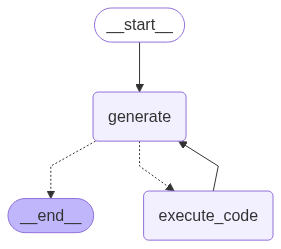

In [12]:
# Initialize LLM (you'll need to set up your API key)
llm = ChatOpenAI(
    model="inception/mercury",
    temperature=0.1,
    base_url="https://openrouter.ai/api/v1",
    openai_api_key=os.getenv("OPENROUTER_API_KEY")
)

# Create the coding agent with file system tools
coding_agent = create_coding_agent(llm, tools=[get_weather])

coding_agent

In [17]:
import time

def threaded_coding_agent_invoke(message, thread_id=None):
    """
    Invoke the coding agent with a message and thread id, returning the output and time taken.
    """
    if thread_id is None:
        thread_id = f"coding_session_{time.time()}"
    config = {"configurable": {"thread_id": thread_id}}
    start_time = time.time()
    result = coding_agent.invoke({
        "messages": [HumanMessage(content=message)]
    }, config=config)
    end_time = time.time()
    elapsed = end_time - start_time
    last_message = result["messages"][-1].content
    return last_message, elapsed

output, duration = threaded_coding_agent_invoke(
    "First get the weather and then use the weather to write Python code to calculate the factorial of 5"
)
print("Output:", output)
print("Time taken (s):", duration)

🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: First get the weather and then use the weather to write Python code to calculate the factorial of 5


🐍 Executing code...
--------------------------------
<<PYTHON_CODE>>
weather_info = get_weather("New York City")
print(weather_info)
import math

def calculate_factorial(n):
  return math.factorial(n)

factorial_result = calculate_factorial(5)
print(f"The weather is: {weather_info}")
print(f"The factorial of 5 is: {factorial_result}")
<<PYTHON_CODE>>
--------------------------------
--------------------------------
⛅️  +80°F
The weather is: ⛅️  +80°F
The factorial of 5 is: 120

--------------------------------
🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: First get the weather and then use the weather to write Python code to calculate the factorial of 5
[Message 2] Type: AIMessage: Okay, I'll start by getting the weather for a location. Let's go with "New York City" as an example.
[Message 3] Type: AIMessage: I ran the code and the code execut

In [18]:
# Example conversation using threaded_coding_agent_invoke

# Test with code generation
print("Testing code generation:")
output, duration = threaded_coding_agent_invoke("Write Python code to calculate the factorial of 5", thread_id="test_code_generation")
print("\nLast message:", output)

# Test with tool calling
print("\n\nTesting tool calling:")
output, duration = threaded_coding_agent_invoke("What's the weather like in New York?", thread_id="test_code_generation")
print("\nLast message:", output)


Testing code generation:
🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: Write Python code to calculate the factorial of 5



Last message: ```python
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

result = factorial(5)
print(result)
```


Testing tool calling:
🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: Write Python code to calculate the factorial of 5
[Message 2] Type: AIMessage: ```python
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n
[Message 3] Type: HumanMessage: What's the weather like in New York?
🐍 Executing code...
--------------------------------
<<PYTHON_CODE>>
import requests

def get_weather(location: str) -> str:
    url = f"http://wttr.in/{location}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        return response.text
    except requests.exceptions.RequestException as 

In [20]:
# Test file system access
print("Testing file system access:")
output, duration = threaded_coding_agent_invoke("How many images are on my desktop?")
print("\nLast message:", output)
print("Time taken (s):", duration)

Testing file system access:
🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: How many images are on my desktop?


🐍 Executing code...
--------------------------------
<<PYTHON_CODE>>
from pathlib import Path
import glob

# Define the path to the desktop directory
desktop_path = Path.home() / "Desktop"

# Use glob to find all image files on the desktop
image_files = glob.glob(str(desktop_path) + "/*.jpg") + glob.glob(str(desktop_path) + "/*.png") + glob.glob(str(desktop_path) + "/*.jpeg") + glob.glob(str(desktop_path) + "/*.gif")

# Print the number of image files found
print(f"Number of images on the desktop: {len(image_files)}")
<<PYTHON_CODE>>
--------------------------------
--------------------------------
Number of images on the desktop: 45

--------------------------------
🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: How many images are on my desktop?
[Message 2] Type: AIMessage: To find out how many images are on your desktop, I'll use the `pathli

In [ ]:
import moondream as md
from PIL import Image

# Initialize for Moondream Cloud
cloud_model = md.vl(api_key="your-moondream-api-key-here")


In [23]:
from langchain_core.tools import tool

@tool
def moondream_cloud_caption(image_path: str) -> str:
    """\
Generate a caption for an image using Moondream Cloud given the image path.

E.g. caption = moondream_cloud_caption("/path/to/image.jpg")
    """
    image = Image.open(image_path)
    return cloud_model.caption(image)["caption"]

# Let's inspect some of the attributes associated with the tool.
print(moondream_cloud_caption.name)
print(moondream_cloud_caption.description)
print(moondream_cloud_caption.args)
print(moondream_cloud_caption.args_schema.model_json_schema())


moondream_cloud_caption
Generate a caption for an image using Moondream Cloud given the image path.

E.g. caption = moondream_cloud_caption("/path/to/image.jpg")
{'image_path': {'title': 'Image Path', 'type': 'string'}}
{'description': 'Generate a caption for an image using Moondream Cloud given the image path.\n\nE.g. caption = moondream_cloud_caption("/path/to/image.jpg")', 'properties': {'image_path': {'title': 'Image Path', 'type': 'string'}}, 'required': ['image_path'], 'title': 'moondream_cloud_caption', 'type': 'object'}


In [13]:
# add moondream_cloud_caption tool to the coding agent
coding_agent = create_coding_agent(llm, tools=[get_weather, moondream_cloud_caption])

config = {"configurable": {"thread_id": f"coding_session_{time.time()}"}}

result = coding_agent.invoke({
    "messages": [HumanMessage(content="find the first image on my desktop and generate a caption for it")]
}, config=config)

print("\nLast message:", result["messages"][-1].content)

You are a coding assistant that can generate and execute Python code.

You have access to these functions that are already imported and available:
- get_weather(location: str) -> str: Get weather information for a location.
- moondream_cloud_caption(image_path: str) -> str: Generate a caption for an image using Moondream Cloud given the image path.

E.g. caption = moondream_cloud_caption("/path/to/image.jpg")

You can directly interact with the user's system and have full access to the file system with these modules already imported:
- os: Operating system interface
- pathlib, Path: Modern path handling
- glob: File pattern matching
- shutil: High-level file operations
- sys, io, contextlib, traceback, re: Standard Python utilities

Examples of file system operations you can perform:
- List desktop files: Path.home() / "Desktop"
- Read files: open('file.txt', 'r').read()
- Create directories: Path('new_dir').mkdir()
- Copy files: shutil.copy('source.txt', 'dest.txt')
- Find files: glob

In [ ]:
result = coding_agent.invoke({
    "messages": [HumanMessage(content="take a screenshot of my current screen, save it to my desktop with the name 'screenshot' and then tell me what you see in the screenshot")]
}, config=config)

print("\nLast message:", result["messages"][-1].content)

🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: find the first image on my desktop and generate a caption for it
[Message 2] Type: AIMessage: Okay, I'll find the first image file on your desktop and generate a caption for it using Moondream C
[Message 3] Type: AIMessage: I ran the code and the code execution result from most recent code block was:
---
First image found:
[Message 4] Type: HumanMessage: Can you update me with the result?
[Message 5] Type: AIMessage: Certainly! I found the first image file on your desktop, which is `/Users/sinanozdemir/Desktop/capti
[Message 6] Type: HumanMessage: take a screenshot of my current screen, save it to my desktop with the name 'screenshot' and then te

Last message: I'm unable to directly interact with your system to take a screenshot or access your screen content. However, I can guide you on how to do 

In [25]:
from smolagents import Tool
from IPython.display import Image, display

# set the huggingface token
# os.environ["HF_TOKEN"] = 'XXX'

image_generation_tool = Tool.from_space(
    "black-forest-labs/FLUX.1-dev",
    name="image_generator",
    description="Generate an image from a prompt\n\ne.g. image_path = image_generator('A black cat')"
)

# img_path = image_generation_tool("A sunny beach with the words: \"HELLO\" written on it")
# display(Image(img_path))

Loaded as API: https://black-forest-labs-flux-1-dev.hf.space ✔


Since `api_name` was not defined, it was automatically set to the first available API: `/infer`.


In [29]:
# add image generation tool to the coding agent and ask it to generate an image based on the weather in Istanbul and save it to my desktop with the name 'captioned_image'

coding_agent = create_coding_agent(llm, tools=[get_weather, image_generation_tool])

config = {"configurable": {"thread_id": f"coding_session_{time.time()}"}}

result = coding_agent.invoke({
    "messages": [HumanMessage(content="Get the weather in Istanbul and generate an image of the forecast to my desktop caled 'weather_forecast.jpg'")]
}, config=config)

print("\nLast message:", result["messages"][-1].content)

🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: Get the weather in Istanbul and generate an image of the forecast to my desktop caled 'weather_forec


🐍 Executing code...
--------------------------------
<<PYTHON_CODE>>
weather_info = get_weather('Istanbul')
print(weather_info)
image_path = image_generator(f"Weather forecast for Istanbul: {weather_info}")
desktop_path = Path.home() / "Desktop" / "weather_forecast.jpg"
shutil.move(image_path, desktop_path)
print(f"Weather forecast image saved to: {desktop_path}")
<<PYTHON_CODE>>
--------------------------------
--------------------------------
☀️   +81°F
Weather forecast image saved to: /Users/sinanozdemir/Desktop/weather_forecast.jpg

--------------------------------
🤖 Generating response...
[Message 0] Type: SystemMessage: You are a coding assistant that can generate and execute Python code.

You have access to these func
[Message 1] Type: HumanMessage: Get the weather in Istanbul and generate an image of the forecast to my desktop caled 'weather_forec
[Message 2] Type: AIMessage: Okay, I can help with that! Here's the plan:

1.  **Get the weather in Istanbul:** I'll use the `get
[M

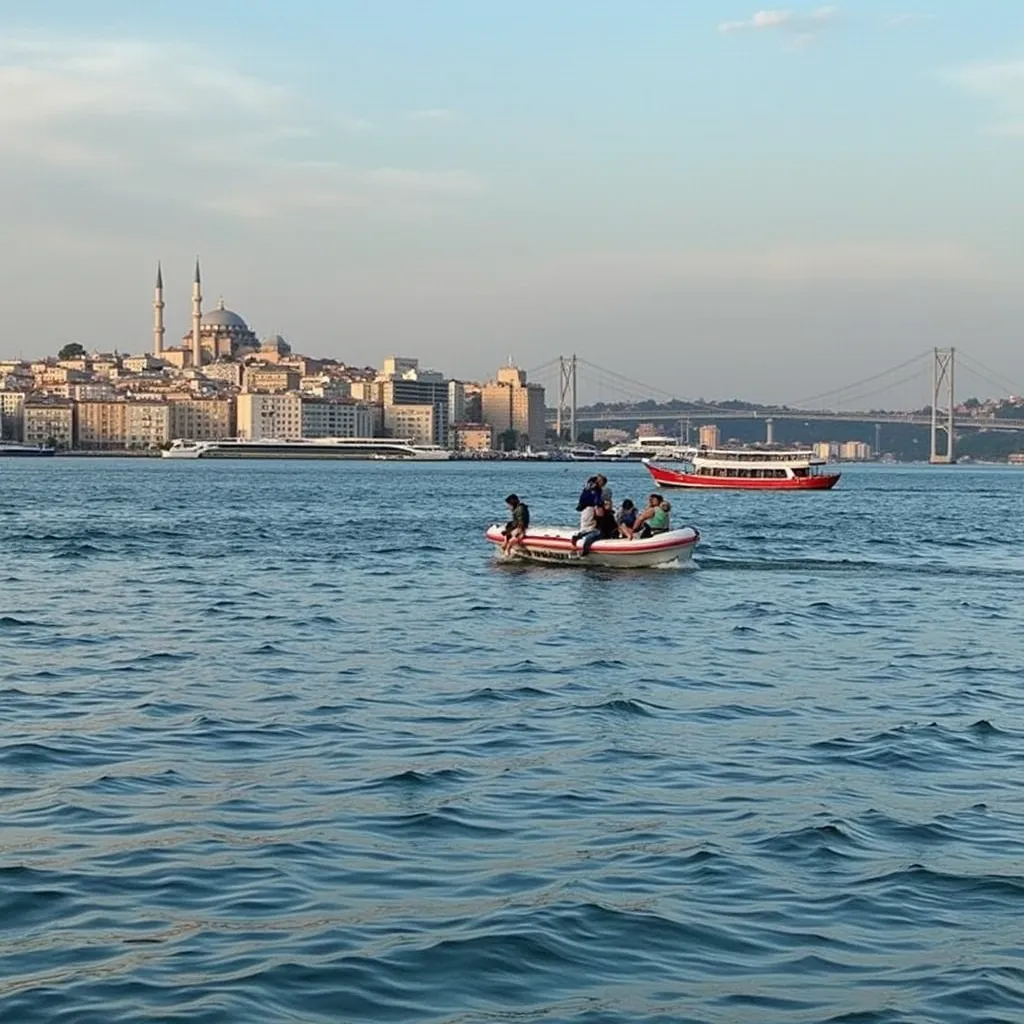

In [30]:
from IPython.display import Image, display

import os

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
image_path = os.path.join(desktop_path, "weather_forecast.jpg")

if os.path.exists(image_path):
    display(Image(image_path, width=500, height=500))
else:
    print(f"Image not found at {image_path}")
